In [55]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
# import tensorflow as tf

In [56]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
from keras.datasets import cifar10
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from numpy.random import shuffle
from numpy import asarray
from numpy.random import randn
import pickle

In [57]:
generator_path = os.getcwd()+"/Model/Generator"
discriminator_path = os.getcwd()+"/Model/Discriminator"
image_path = os.getcwd()+"/Images"
if not os.path.exists(generator_path) and not os.path.exists(discriminator_path):
    os.makedirs(generator_path)
    os.makedirs(discriminator_path)
    f= open("fid.csv","a")
    f.close()
if not os.path.exists(image_path):
    os.makedirs(image_path)


In [58]:
# # import the data
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # fuse the training set and the testing set
# #x_train = np.concatenate((x_train, x_test), axis = 0)/255

img_rows = 32
img_cols = 32
channels = 3

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# # Size of the noise vector, used as input to the Generator
z_dim = 100

# # check some images
# fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=6, sharey=True, sharex=False)
# for i in range(6):
#     axes[i].xaxis.set_visible(False)
#     axes[i].yaxis.set_visible(False)
#     im = axes[i].imshow(x_train[i],interpolation='bicubic')

### Generator 

In [59]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 4 * 4, input_dim=z_dim))
    model.add(Reshape((4, 4, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2D(3, kernel_size=(3,3), padding='same', activation = 'tanh'))

    # Output layer with tanh activation
    print(model.output_shape)
    return model

### Discriminator 

In [60]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=(3,3), input_shape=img_shape, padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same'))

    

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    # Output layer with sigmoid activation
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.output_shape)
    return model

In [61]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)
    generator.summary()
    discriminator.summary()
    return model

### Model

In [62]:
from os import listdir
from os.path import isfile, join
import re 
    
if(len(listdir(generator_path)) > 0 and len(listdir(generator_path))>0):
    print("Loading existing models.")
    
    gen_files = [f for f in listdir(generator_path) if isfile(join(generator_path, f))]
    disc_files = [f for f in listdir(discriminator_path) if isfile(join(discriminator_path, f))]
    #print(onlyfiles)
    def extract_number(f):
        s = re.findall("\d+$",f)
        return (int(s[0]) if s else -1,f)

    print("Generator Model: "+max(gen_files,key=extract_number))
    print("Discriminator Model: "+max(disc_files,key=extract_number))
    
    gen_file = max(gen_files,key=extract_number)
    disc_file = max(disc_files, key=extract_number)
    discriminator = keras.models.load_model(discriminator_path+"/"+disc_file)
    discriminator.compile(optimizer = Adam(0.0004), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    generator = keras.models.load_model(generator_path+"/"+gen_file)
    #generator.compile(loss='binary_crossentropy')
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))
else:
    # Build and compile the Discriminator
    print("Creating new models")
    discriminator = build_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0004),
                          metrics=['accuracy'])

    # Build the Generator
    generator = build_generator(z_dim)
    # Keep Discriminator’s parameters constant for Generator training
    discriminator.trainable = False

    # Build and compile GAN model with fixed Discriminator to train the Generator
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))
    gan.summary()


Creating new models
(None, 1)
(None, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4096)              413696    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT

### Training

In [63]:
BATCH_SIZE = 64

# # Get training images
(train_images, train_labels), (test_images, _) = cifar10.load_data()

# Select Cars
# train_images = train_images[train_labels[:,0]==1]
print ("Training shape: {}".format(train_images.shape))

# Normalize data
train_images = (train_images - 127.5) / 127.5
 
num_batches = int(train_images.shape[0]/BATCH_SIZE)

fid_list = []


Training shape: (50000, 32, 32, 3)


### Image Generation

In [64]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_imgs(epoch):
    noise = generate_noise(9, 100)
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(3, 3)
    count = 0
    for i in range(3):
        for j in range(3):
      # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            count += 1
    plt.savefig(fname=image_path+'/image_at_epoch_{:04d}.png'.format(epoch)) 
    plt.show()
    plt.close()

### FID

In [65]:
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# compute the FID scores
def compute_fid(generator, test_input, epoch):
    predictions = generator.predict(test_input)
    predictions_fid = ((predictions[:, :, :, :] * 127.5 + 127.5))
    predictions_fid = predictions_fid.astype('float32')
    predictions_fid = scale_images(predictions_fid , (299,299,3))
    print(type(predictions_fid))
    print('Calculating the FID Score...')

    # pre-process images
    predictions_fid = preprocess_input(predictions_fid)
    print(predictions_fid.shape)
    test_images_fid1 = preprocess_input(test_images_fid)
    print(test_images_fid1.shape)
    # calculate fid
    fid = calculate_fid(model_fid, predictions_fid, test_images_fid1)
    print('FID: %.3f' % fid)
    fid_list.append((epoch,fid))
    return fid
    

In [66]:
test_images_fid = test_images.astype('float32')
test_images_fid = test_images_fid[:1000,:]
#test_images_fid =((test_images_fid - 127.5)/127.5)
test_images_fid = scale_images(test_images_fid, (299,299,3))
model_fid = InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299,3))

  Epoch: 1, Generator Loss: 2.483382589075233, Discriminator Loss: 0.32748858815729237


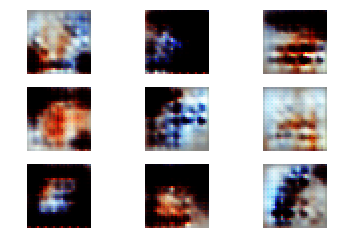

  Epoch: 2, Generator Loss: 2.498826716376633, Discriminator Loss: 0.3415023258263567


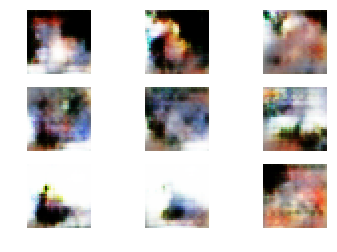

  Epoch: 3, Generator Loss: 2.4126148706209034, Discriminator Loss: 0.360188791068049


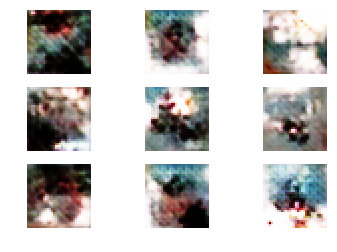

  Epoch: 4, Generator Loss: 2.3868754219917268, Discriminator Loss: 0.36871148811870286


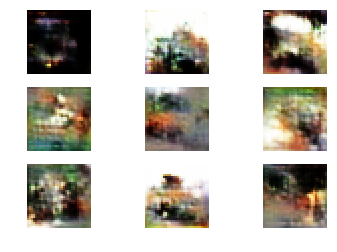

  Epoch: 5, Generator Loss: 2.353960373032261, Discriminator Loss: 0.37580234457222356


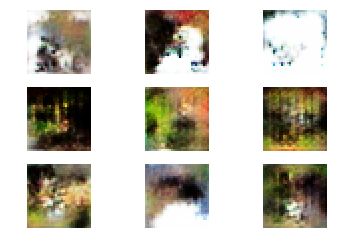

<class 'numpy.ndarray'>
Calculating the FID Score...
(1000, 299, 299, 3)
(1000, 299, 299, 3)


ValueError: m has more than 2 dimensions

In [68]:
gen_losses = []
disc_losses = []
N_EPOCHS = 300

for epoch in tqdm(range(N_EPOCHS)):

    cum_d_loss = 0.
    cum_g_loss = 0.
    g_loss = 0
    d_loss = 0
    for batch_idx in range(num_batches):
        # Get the next set of real images to be used in this iteration
        images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

        noise_data = generate_noise(BATCH_SIZE, 100)
        generated_images = generator.predict(noise_data)
        
        # Train on soft labels (add noise to labels as well)
        noise_prop = 0.05 # Randomly flip 5% of labels

        # Prepare labels for real data
        true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
        true_labels[flipped_idx] = 1 - true_labels[flipped_idx]

        # Train discriminator on real data
        d_loss_true = discriminator.train_on_batch(images, true_labels)

        # Prepare labels for generated data
        gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
        gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]

        # Train discriminator on generated data
        d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

        d_loss, accuracy = 0.5 * np.add(d_loss_true, d_loss_gene)
        cum_d_loss += d_loss

        # Train generator
        noise_data = generate_noise(BATCH_SIZE, 100)
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        
        gen_losses.append(g_loss)
        disc_losses.append(d_loss)
            
        cum_g_loss += g_loss

    print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    show_imgs(epoch)
    #print(' Accuracy: {}'.format(accuracy))
    
    if (epoch + 1) % 50 == 0:
        print("Saving Models")
        discriminator.trainable = True
        generator.save(generator_path+"/generator_{:04d}.h5".format(epoch))
        discriminator.save(discriminator_path+"/discriminator_{:04d}.h5".format(epoch))
        discriminator.trainable = False
        discriminator.compile(optimizer = Adam(0.0004), loss='binary_crossentropy', metrics=['accuracy'])
        gan = build_gan(generator, discriminator)
        gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))
        
        
    if (epoch+1) % 5 == 0:
        test_input = generate_noise(1000,100)
        current_fid = compute_fid(generator, test_input, epoch)
        row = [epoch, current_fid, g_loss, d_loss]
        with open('fid.csv', 'a') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(row)

In [ ]:
# if(os.path.isfile(model_path+'/objs.pkl')):
#     with open(model_path+'/objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#         fid_list, gen_losses, disc_losses = pickle.load(f)
#         print(fid_list)
#         print(gen_losses)
#         print(disc_losses)

In [ ]:
gen_losses = np.array(gen_losses)
disc_losses = np.array(disc_losses)

# with open(filename, "a") as outfile:
#     writer = csv.writer(outfile, escapechar=' ', quoting=csv.QUOTE_NONE)
#     writer.writerow(["Gen_Losses", "Disc_Losses"])
#     writer.writerow([gen_losses, disc_losses])

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(disc_losses, label="Discriminator loss")
plt.title("Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(gen_losses, label="Generator loss")

plt.title("Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fid_list = np.array(fid_list)
print(fid_list)
# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(fid_list.T[1], label="FID values")


#plt.xticks(fid_list.T[0], rotation=90)

plt.title("FID values per 100 epochs")
plt.xlabel("Iteration")
plt.ylabel("FID Value")
plt.legend()

In [ ]:
#gan.summary()

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [ ]:
# load model
# model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = generator.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:
vector = generate_latent_points(100, 1)
print(vector.shape)
# generate image
X = generator.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plt.imshow(X[0, :, :])
plt.show()

In [ ]:
import imageio
import glob 
#import files

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(image_path+'/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)

#files.download(anim_file)

In [ ]:

# losses = []
# accuracies = []
# iteration_checkpoints = []


# def train(iterations, batch_size, sample_interval):

#     # Load the MNIST dataset
#     (X_train, _), (_, _) = cifar10.load_data()

#     # Rescale [0, 255] grayscale pixel values to [-1, 1]
#     X_train = X_train / 127.5 - 1.0
#     #print(X_train.shape)
#     #X_train = np.expand_dims(X_train, axis=3)

#     # Labels for real images: all ones
#     real = np.ones((batch_size, 1))

#     # Labels for fake images: all zeros
#     fake = np.zeros((batch_size, 1))

#     for iteration in tqdm(range(iterations)):

#         # -------------------------
#         #  Train the Discriminator
#         # -------------------------

#         # Get a random batch of real images
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         imgs = X_train[idx]

#         # Generate a batch of fake images
#         z = np.random.normal(0, 1, (batch_size, 100))
#         gen_imgs = generator.predict(z)
#         # Train Discriminator
#         d_loss_real = discriminator.train_on_batch(imgs, real)
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
#         d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # ---------------------
#         #  Train the Generator
#         # ---------------------

#         # Generate a batch of fake images
#         z = np.random.normal(0, 1, (batch_size, 100))
#         gen_imgs = generator.predict(z)

#         # Train Generator
#         g_loss = gan.train_on_batch(z, real)

#         if (iteration + 1) % 50 == 0:
#             discriminator.trainable = True
#             discriminator.trainable = False
#             generator.save(model_path+"/generator.h5")
#             discriminator.save(model_path+"/discriminator.h5")
        
#         if (iteration + 1) % sample_interval == 0:

#             # Save losses and accuracies so they can be plotted after training
#             losses.append((d_loss, g_loss))
#             accuracies.append(100.0 * accuracy)
#             iteration_checkpoints.append(iteration + 1)

#             # Output training progress
#             print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
#                   (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

#             # Output a sample of generated image
#             show_imgs("Iteration" + str(iteration))

In [ ]:
# # Set hyperparameters
# iterations = 10000
# batch_size = 128
# sample_interval = 100

# # Train the DCGAN for the specified number of iterations
# train(iterations, batch_size, sample_interval)

In [ ]:
# losses = np.array(losses)

# # Plot training losses for Discriminator and Generator
# plt.figure(figsize=(15, 5))
# plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
# plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

# plt.xticks(iteration_checkpoints, rotation=90)

# plt.title("Training Loss")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.legend()

In [ ]:
# accuracies = np.array(accuracies)

# # Plot Discriminator accuracy
# plt.figure(figsize=(15, 5))
# plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

# plt.xticks(iteration_checkpoints, rotation=90)
# plt.yticks(range(0, 100, 5))

# plt.title("Discriminator Accuracy")
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy (%)")
# plt.legend()